### Standard imports and Process Creation

In [1]:
from hello.pid.lvpid import PIDController
from hello.pid.delay import seconds, minutes, hours, days, m2s, s2m, h2s, DelaySink, DelayBuffer
import numpy as np
from hello.pid.gas_process import GasController, HeadspaceProcess
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
%matplotlib

Using matplotlib backend: TkAgg


In [2]:
# Henry's law
def calc_hcp(T):
    C = 2400 
    T0 = 298
    hcp0 = 3.4e-2
    return hcp0*np.exp(C*(1/T - 1/T0))
hcp = calc_hcp(T=273.15 + 37)

# The base pump is kind of stupid, and doesn't really give a reliable relationship between
# base duty and flow rate. Instead, it follows different linear fits depending whether it 
# is above or below 50% base duty. 

class BaseProcess():
    def __init__(self, acid=0.5, m1=4.61, b1=-0.0246, mid=.55, m2=1.75, b2=1.4565):
        self.m1 = m1
        self.b1 = b1
        self.m2 = m2
        self.b2 = b2
        self.mid = mid
        self.acid = acid / 1000  # mol / milliliter 
        self.added = 0
        
    def request(self, pc):
        if pc < 0.01:
            v1 = self.m1*.01 + self.b1
            v = (v1-0)*(pc)/.01
        elif pc < self.mid:
            v = self.m1*pc + self.b1
        else:
            v = self.m2*pc + self.b2
        if v < 0:
            return 0
        return v
       
    def step(self, pc):
        ml = self.request(pc)
        mol = ml * self.acid
        self.added += ml
        return ml, mol

In [3]:
TOTAL_RVOLUME = {
    3: 4,
    15: 17,
    80: 90,
}

def qf(a,b,c):
    return (-b+np.sqrt(b**2-4*a*c))/(2*a)

def ph_to_co2(ph, hco3, hcp=hcp):
    h = 10**(-ph)
    w = 1e-7
    ka = 4.45e-7
    bc = hco3 + h - w
    co2 = bc * h / ka
    return co2 / hcp

def general_ph(c1, c2, c3, ka):
    a = 1
    b = c2+c3+ka
    c = c2*c3-ka*c1
    x=qf(a,b,c)
    return -np.log10(c2+x)

def cpH(co2, bicarb, hcp=hcp):
    # co2 as fraction of atmosphere
    c1 = co2 * hcp # henry's law
    c2 = 1e-7
    c3 = bicarb
    ka = 4.45e-7  # pka 6.35
    a = 1
    b = c2+c3+ka
    c = c2*c3-ka*c1
    x=qf(a,b,c)
    return -np.log10(c2+x)

def equil(c1, c2, c3, ka, alpha=1):
    """ Calculate equilibrium for the reaction A -> B + C.
    Includes an optional alpha parameter to "slow" the reaction rate. 
    """
    a = 1
    b = c2+c3+ka
    c = c2*c3 - ka*c1
    x = qf(a,b,c)
    x *= alpha
    return c1-x, c2+x, c3+x

def equil2(dx, c1, c2, c3, ka):
    """ Calculate equilibrium concentration of c1, c2, c3 given Ka and given that
    the final concentration of c1 is c1 + dx. 
    
    E.g. CO2 <-> H+ + HCO3-. We know [CO2] changed by dx, what is new concentration
    of H+ and HCO3-? You can approximate this with an ICEbox if you assume x <<< c1,
    and therefore c1 doesn't change, but there's a way to use math to get an exact answer.
    """
    # Optimize bytecode a bit because
    # this equation is in the inner loop
    
    c2_c3_2 = (c2+c3) / 2
    dy = np.sqrt(ka*(c1+dx)-c2*c3 + c2_c3_2*c2_c3_2) - c2_c3_2
    
    e1 = c1 + dx
    e2 = c2 + dy
    e3 = c3 + dy
    
    return e1, e2, e3

def co2_to_ph(co2, bicarb, hcp):
    # co2 as fraction of atmosphere
    c = co2 * hcp # henry's law
    ka = 4.45e-7  # pka 6.35
    h = ka * c / bicarb
    return -np.log10(h)


class pHProcess():
    """ pH Process
    Uses cascaded calculation model,
    First using HeadspaceProcess to estimate
    headspace gas concentrations, and using
    the result to calculate change in PV. 
    """
    
    # First order constant
    k_80L = default_k = (-0.19053+-0.17422)/2
    k_15L = default_k * 0.19314 / 0.1306 
    k_3L  = -0.22
    
    # Consumption rate
    default_c = 0
    
    # volume fraction of CO2, N2, O2 in air
    # note the remaining 1% is trace gasses
    AIR_CNO = (0.0004, 0.7809, 0.2095)
    
    def __init__(self, main_gas=1, initial_pv=7, initial_cno=AIR_CNO, reactor_size=80, volume=55, delay=0,
                 bicarb=2.02, temp=37, stock_bicarb=0.5, base_interlock=17):
        """
        :param g: gain in units of C/min/%
        :param k: decay rate in units of C/min/dT
        :param bicarb: bicarbonate concentration in g/L
        :param stock_bicarb: base concentration in mol/L bicarb
        """
        self.sink = DelayBuffer(delay, initial_pv)
        self.delay = self.sink.cycle
        
        self.hcp = calc_hcp(temp+273.15)
        self.k = 0
        self.k_mult = 0
        self._k = 0
        self.c = 0
        self.dc = 0
        self.d2c = 0
        self.set_values(k=self.default_k, k_mult=1, c=self.default_c, dc=0, d2c=0)
        self._bicarb = bicarb / 84  # moles / L
        self._co2 = ph_to_co2(initial_pv, self._bicarb, self.hcp)
        if self._co2 > 1:
            self._co2 = 1
        if self._co2 < 0:
            self._co2 = 0
        self._h = 10**(-initial_pv)
        
        self._reactor_size = reactor_size
        self._volume = volume
        self.main_gas = main_gas
    
        hs_volume = TOTAL_RVOLUME[reactor_size] - volume
        c, n, o = initial_cno
        self.hp = HeadspaceProcess(hs_volume, c, n, o)
        self.bp = BaseProcess(stock_bicarb)
        self.base_interlock = base_interlock
        
    @property
    def volume(self): 
        return self._volume
    
    def set_values(self, **kw):
        if any(not hasattr(self, a) for a in kw):
            raise KeyError(next(set(kw) - set(dir(self))))
            
        if kw.get('k') is not None or kw.get('k_mult') is not None:
            if kw.get('k') is not None:
                self.k = kw['k'] / 3600
            
            if kw.get('k_mult') is not None:
                self.k_mult = kw['k_mult']
                
            self._k = self.k_mult * self.k
    
        if kw.get('c') is not None:
            self.c = kw['c'] / 3600
        if kw.get('dc') is not None:
            self.dc = kw['dc'] / 3600 / 3600
        if kw.get('d2c') is not None:
            self.d2c = kw['d2c'] / 3600 / 3600 / 3600
            
        if kw.get('delay') is not None:
            self.sink.set_delay(kw['delay'])
            
        if kw.get('T') is not None:
            self.hcp = calc_hcp(kw['T']+273.15)
            
        if kw.get("hco3") is not None:
            self._bicarb = max(0, kw["hco3"]/84)
    
    @volume.setter
    def volume(self, v):
        self._volume = v
        self.hp.vol = TOTAL_RVOLUME[self._reactor_size] - v

    def step(self, co2_req, n2_req, o2_req, air_req, base_req):

        # Headspace Gassing
        self.hp.calc_gas(self.main_gas, co2_req, n2_req, o2_req, air_req)
        co2_hs = self.hp.co2A
        
        # Arbitrary acid generation
        self.dc += self.d2c
        self.c += self.dc
        self._h += self.c
        
        # CO2 In/Out gassing from solution
        dco2 = self._k * (self._co2 - co2_hs)
        co2 = self._co2 + dco2
    
        if co2 < 0:
            co2 = 0
            dco2 = -self._co2

        # Base flow, only if there's volume left to flow base (interlock).
        # Base step functions returns mL of liquid added, and mol of bicarbonate
        # Added. 
        if self._volume < self.base_interlock:
            ml, mol = self.bp.step(base_req)
            l = ml / 1000
            self.hp.vol -= l
            if self.hp.vol < 0:
                self.hp.vol = 0
            self._bicarb = (self._bicarb * self._volume + mol) / (self._volume + l)
            self._volume += l
            if self._bicarb < 0:
                self._bicarb = 0
        
        # `equil()` can choke if co2 is too low, because it calculates using a 
        # very small (or 0) final concentration of CO2, which may make no physical sense
        co2, h, bc = equil(co2*self.hcp, self._h, self._bicarb, 4.45e-7)
        self._h = h
        self._bicarb = bc
        self._co2 = co2 / self.hcp
        return -np.log10(h)
    
    _method = 2

In [4]:
def equil3(c1, c2, k):
    x = (k * c1 - c2) / (1 + k)
    return c1-x, c2+x

class CarbonicAcidProcess():
    def __init__(self, co2, h2co3, h, hco3):
        self.k1 = 4.45e-7
        self.ktrue = 2.0e-4
        self.k0 = 450
        
        self.co2 = co2
        self.h2co3 = h2co3
        self.h = h
        self.hco3 = hco3
        
    def adjust(self, dco2=0, dh2co3=0, dh=0, dhco3=0):
        co2 = self.co2 + dco2
        h2co3 = self.h2co3 + dh2co3
        h = self.h + dh
        dhco3 = self.hco3 + dhco3
        
        co2, h2co3 = equil3(co2, h2co3, )
        
        h2co3, h, hco3 = equil(h2co3, h, hco3, self.k1)
        

In [5]:
import json
from pysrc.snippets import OptionCategory

class PIDOps(OptionCategory):
    p = 5
    i = 5
    d = 0
    amax = 100
    amin = 0
    alpha = 1
    beta = 1
    linearity = 1
    gamma = 0
    deadband = 0
    man_request = 0
    mode = 0
    
class MFCOps(OptionCategory):
    co2_max = 1
    o2_max = 2
    n2_max = 10
    air_max = 10
    
class PlotOps(OptionCategory):
    xscale = 'auto'
    xmin = 0
    xmax = 72
    xscale_factor = 3600

class SimOps(OptionCategory):
    
    co2_pid = PIDOps()
    co2_pid.p = -200
    co2_pid.i = 2
    co2_pid.d = 0
    co2_pid.amax = 100
    co2_pid.amin = 0
    co2_pid.beta = 1
    co2_pid.linearity = 1
    co2_pid.alpha = -1
    
    base_pid = PIDOps()
    base_pid.p = 20
    base_pid.i = 2
    base_pid.d = 0
    base_pid.amax = 100
    base_pid.amin = 0
    base_pid.beta = 0
    base_pid.linearity = 1
    base_pid.alpha = -1

    mfcs = MFCOps()
    mfcs.co2_max = 1
    mfcs.o2_max = 10
    mfcs.n2_max = 10
    mfcs.air_max = 10
    
    delay = 0
    end = 10000
    initial_actual_cno = pHProcess.AIR_CNO
    initial_request_cno = (0.07, 0, 0)
    initial_request_base = 0
    initial_pv = 90
    set_point = 40
    set_point_deadband = 1
    k_mult = 1.1
    k = None
    c = None
    dc = 0
    d2c = 0
    mode = "m2a"
    main_gas = 1.0
    reactor_size = 80
    reactor_volume = reactor_size * 55/80
    time_unit = hours
    max_iters = 3 * days
    bicarb = 3.7  # g/L
    temp = 37
    base_bicarb = 0.5  # mol/L
    hcalc_method = "h+"
    base_interlock = 17


In [6]:
ops = SimOps()

ops.co2_pid.p = -200
ops.co2_pid.i = 2
ops.co2_pid.d = 0
ops.co2_pid.amax = 30
ops.co2_pid.amin = 0
ops.co2_pid.alpha = -1
ops.co2_pid.linearity = 1
ops.co2_pid.beta = 0
ops.co2_pid.gamma = 0
ops.co2_pid.deadband = 0
ops.co2_pid.man_request = 0
ops.co2_pid.mode = 0

ops.base_pid.p = 20
ops.base_pid.i = 2
ops.base_pid.d = 0
ops.base_pid.amax = 20
ops.base_pid.amin = 0
ops.base_pid.alpha = -1
ops.base_pid.beta = 1
ops.base_pid.linearity = 1
ops.base_pid.gamma = 0
ops.base_pid.deadband = 0
ops.base_pid.man_request = 0
ops.base_pid.mode = 0

ops.mfcs.co2_max = 1
ops.mfcs.o2_max = 2
ops.mfcs.n2_max = 10
ops.mfcs.air_max = 10

ops.delay = 0
ops.end = 10*hours
ops.initial_actual_cno = pHProcess.AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 7
ops.set_point = 7.21
ops.set_point_deadband = 0.02
ops.k = pHProcess.default_k
ops.k_mult = 1.0
ops.c = 0
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 1.0
ops.reactor_size = 80
ops.reactor_volume = 55
ops.time_unit = hours
ops.max_iters = 7 * days
ops.bicarb = 3.7
ops.temp = 37
ops.base_bicarb = 0.5
ops.hcalc_method = "h+"
ops.base_interlock = 17

In [36]:
from hello.pid.plots import RingBuffer

class DataQueue():
    """ Standard data container for a single set of data.
    Stores permenant data internally in a RingBuffer.
    For performance reasons, store pending values 
    in a simple python list, and push them to the 
    permanent buffer only when explicitly requested. 
    """
    def __init__(self, pts):
        self._values = RingBuffer(pts)
        self._pending = []
        self.put = self._pending.append
        
    def __len__(self):
        return len(self._values)
        
    def push(self):
        self._values.extend(self._pending)
        self._pending.clear()
        self.put = self._pending.append
        
    def get(self):
        self.push()
        return self._values.get()

    def clear(self):
        self._values.clear()
        self._pending.clear()
        
    def resize(self, new_sz):
        self.push()
        nv = RingBuffer(new_sz)
        nv.extend(self.get())
        self._values = nv

        
def _mk_pid(pidops, pv, sp, req, mode):
    c = PIDController(pgain=pidops.p,               itime=pidops.i,
                      dtime=pidops.d,               auto_max=pidops.amax,
                      auto_min=pidops.amin,       
                      beta=pidops.beta,
                      linearity=pidops.linearity,   alpha=pidops.alpha,
                      deadband=pidops.deadband,     sp_high=100, sp_low=0,
                      gamma=pidops.gamma,           man_request=pidops.man_request,
                      mode=pidops.mode)
    if mode == "o2a":
        c.off_to_auto(pv, sp)
    elif mode == "m2a":
        c.man_to_auto(pv, sp, req)
    elif mode == "a2a":
        c.man_to_auto(pv, pv, req)
    else:
        raise ValueError(mode)
    return c
        
        
class pHSim():
    def __init__(self, ops, pts=None):
        self.ops = ops
        if pts is None:
            pts = ops.end
        self._mi = self.ops.max_iters
        self._data = {}
        self._pts = pts
        vars = [
            "x", "pv", "c", 
            "co2", "n2", "o2", "air", "base",
            "co2sln", "co2hs",
            "co2uk", "co2up", "co2ui", "co2ud",
            "baseuk", "baseup", "baseui", "baseud",
            "vol", "bc", "hpv",
        ]
        for v in vars:
            self._add_queue(v)
            
        pv = ops.initial_pv
        sp = ops.set_point
        db = ops.set_point_deadband
        co2_req, n2_req, o2_req = ops.initial_request_cno
        co2a, n2a, o2a = ops.initial_actual_cno
        
        def minmax(v): return min(100, max(v, 0))
        co2_req = minmax(co2_req)
        n2_req = minmax(n2_req)
        o2_req = minmax(o2_req)
        co2a = minmax(co2a)
        n2a = minmax(n2a)
        o2a = minmax(o2a)
        
        base_req = ops.initial_request_base
        air_req = max(1-co2_req - n2_req - o2_req, 0)
            
        self._co2_pid = _mk_pid(ops.co2_pid, 10**(8-pv), 10**(8-(sp+db)), co2_req*100, ops.mode)
        self._base_pid = _mk_pid(ops.base_pid, 10**(8-pv), 10**(8-(sp-db)), base_req*100, ops.mode)
            
        delay = ops.delay
        mg = ops.main_gas
    
        self._proc = pHProcess(mg, pv,     (co2a, n2a, o2a), 
                     ops.reactor_size, ops.reactor_volume, 
                     ops.delay, ops.bicarb, ops.temp, ops.base_bicarb, ops.base_interlock)
    
        self._proc.set_values(k=ops.k, k_mult=ops.k_mult, c=ops.c, dc=ops.dc, d2c=ops.d2c)
        self._ctrl = GasController(ops.mfcs.co2_max, ops.mfcs.n2_max, ops.mfcs.o2_max, ops.mfcs.air_max)
        self._time_unit = ops.time_unit
            
        self._state = s = {}
        s['t'] = 0
        s['sp'] = sp
        s['db'] = db
        s['pv'] = pv
        s['co2_req'] = co2_req
        s['n2_req'] = n2_req
        s['o2_req'] = o2_req
        s['base_req'] = base_req
        s['air_req'] = air_req
        s['mg'] = mg
        s['co2a'] = co2a
        s['n2a'] = n2a
        s['o2a'] = o2a
        s['c'] = self._proc.c * 3600
        s['dc'] = self._proc.dc * 3600 * 3600
        s['d2c'] = self._proc.d2c * 3600 * 3600 * 3600
        
    @property
    def state(self):
        return self._state.copy()
        
    def _add_queue(self, name):
        if name in self._data:
            raise ValueError(name)
        self._data[name] = DataQueue(self._pts)
        setattr(self, "_"+name, self._data[name])
        
    def getq(self, name):
        return self._data[name]
    
    def get(self, name):
        return self.getq(name).get()
    
    def legacy_data(self):
        """ Sloppily return data in legacy format 
        so I don't have to refactor a bunch of functions. 
        """
        sim = self
        data = list(zip(sim._x.get(), sim._pv.get(), sim._c.get(),
                         sim._co2.get(), sim._n2.get(), sim._o2.get(), sim._air.get(), sim._base.get()))
        data2 = list(zip(sim._co2uk.get(), sim._co2up.get(), sim._co2ui.get(), sim._co2ud.get()))
        data3 = list(zip(sim._baseuk.get(), sim._baseup.get(), sim._baseui.get(), sim._baseud.get()))
        data4 = sim._co2sln.get(), sim._co2hs.get(), sim._vol.get(), sim._bc.get()
        return data, data2, data3, data4
        
    def sim_iters(self, iters=0):
        
        if iters > self._mi:
            iters = self._mi
        if iters <= 0:
            return
            
        # Optimize bytecode a bit...
        _x = self._x
        _co2 = self._co2
        _pv = self._pv
        _c = self._c
        _co2 = self._co2
        _n2 = self._n2
        _o2 = self._o2
        _air = self._air
        _base = self._base
        _co2sln = self._co2sln
        _co2hs = self._co2hs
        _co2uk = self._co2uk
        _co2up = self._co2up
        _co2ui = self._co2ui
        _co2ud = self._co2ud
        _baseuk = self._baseuk
        _baseup = self._baseup
        _baseui = self._baseui
        _baseud = self._baseud
        _vol = self._vol
        _bc = self._bc
        _hpv = self._hpv
        
        s = self._state
        t = s['t']
        sp = s['sp']
        db = s['db']
        mg = s['mg']
        n2_req = s['n2_req']
        o2_req = s['o2_req']
        air_req = s['air_req']
        pv = s['pv']
        
        co2_sp = sp
        base_sp = sp
        time_unit = self._time_unit
        proc = self._proc
        ctrl = self._ctrl
        co2_pid = self._co2_pid
        base_pid = self._base_pid
        
        # v2.0 / v3.0.3+ controller interlock support
        co2_limit = sp + db
        base_limit = sp - db
        co2_interlock = pv < co2_limit
        base_interlock = pv > base_limit
        
        while iters > 0:
            iters -= 1
            t += 1
            h_pv = pv #  10**(8-pv)
            
            if pv >= co2_limit:
                if co2_interlock:
                    co2_interlock = False
                    co2_pid.set_mode(co2_pid.AUTO, pv, co2_sp)
            else:
                co2_interlock = True
                co2_pid.set_mode(co2_pid.OFF, 0, 0)
                
            if pv <= base_limit:
                if base_interlock:
                    base_interlock = False
                    base_pid.set_mode(base_pid.AUTO, pv, base_sp)
            else:
                base_interlock = True
                base_pid.set_mode(base_pid.OFF, 0, 0)
            
                    
            co2_req = co2_pid.step(h_pv, co2_sp) / 100
            base_req = base_pid.step(h_pv, base_sp) / 100
            co2_flow, n2_flow, o2_flow, air_flow = ctrl.request(mg, co2_req, n2_req, o2_req)
            pv = proc.step(co2_flow, n2_flow, o2_flow, air_flow, base_req)

            _x.put(t/time_unit)
            _pv.put(pv)
            _hpv.put(h_pv)
            _c.put(proc.c * 3600)

            _co2.put(co2_flow)
            _n2.put(n2_flow)
            _o2.put(o2_flow)
            _air.put(air_flow)
            _base.put(base_req)

            _co2sln.put(proc._co2)
            _co2hs.put(proc.hp.co2A)

            _co2uk.put(co2_pid.Uk)
            _co2up.put(co2_pid.Up)
            _co2ui.put(co2_pid.Ui)
            _co2ud.put(co2_pid.Ud)

            _baseuk.put(base_pid.Uk)
            _baseup.put(base_pid.Up)
            _baseui.put(base_pid.Ui)
            _baseud.put(base_pid.Ud)

            _vol.put(proc.bp.added)
            _bc.put(proc._bicarb)
            
        s['t'] = t
        s['sp'] = sp
        s['db'] = db
        s['pv'] = pv
        s['co2_req'] = co2_req
        s['n2_req'] = n2_req
        s['o2_req'] = o2_req
        s['base_req'] = base_req
        s['air_req'] = air_req
        s['mg'] = mg
        s['co2a'] = proc.hp.co2A
        s['n2a'] = proc.hp.n2A
        s['o2a'] = proc.hp.o2A
        s['c'] = self._proc.c * 3600
        s['dc'] = self._proc.dc * 3600 * 3600
        s['d2c'] = self._proc.d2c * 3600 * 3600 * 3600
        
    def set_time(self, t):
        self._state['t'] = t
        
    def set_process_value(self, name, value):
        if name == "delay":
            value *= 60
        self._proc.set_values(**{name:value})
        
    def set_pid_value(self, pid, param, value):
        if pid[:3] == "co2":
            pid = self._co2_pid
        elif pid[:4] == "base":
            pid = self._base_pid
        else:
            print("Invalid PID: %r" % pid)
            return
        
        if param == "pgain":
            pid.pgain = value
        elif param == "itime":
            pid.itime = m2s(value)
        elif param == "dtime":
            pid.dtime = m2s(value)
        elif param == "beta":
            pid.b = value
        elif param == "mode":
            sp = self._state['sp']
            if pid == self._co2_pid:
                sp += self._state['db']
            else:
                sp -= self._state['db']
            pid.set_mode(value, 10**(8-self._state['pv']), 10**(8-sp))
        elif param == "man":
            pid.man_request = float(value)
        else:
            print("Invalid parameter: %r" % param)
    
    def set_value(self, name, value):
        if name in self._state:
            self._state[name] = value
            if name == "mg":
                self._proc.main_gas = value
        else:
            print("Error Invalid Value: %r" % name)

    def clear_data(self):
        for q in self._data.values():
            q.clear()
        self._state['t'] = 0

    def resize(self, n):
        for q in self._data.values():
            q.resize(n)

In [37]:
def ph_sim(ops):
    # standalone sim function compatible with the do_sim_coroutine
    # function used for interactive use
    global state
    state = {}
    
    class MyList(list):
        put = list.append
    
    xq = MyList()
    pvq = MyList()
    cq = MyList()
    co2q = MyList()
    n2q = MyList()
    o2q = MyList()
    aq = MyList()
    baseq = MyList()
    co2ukq = MyList()
    co2upq = MyList()
    co2uiq = MyList()
    co2udq = MyList()
    baseukq = MyList()
    baseupq = MyList()
    baseuiq = MyList()
    baseudq = MyList()
    co2slnq = MyList()
    co2hsq = MyList()
    vq = MyList()
    bcq = MyList()
    
    coro = ph_sim_coroutine(ops, state, xq, pvq, cq,
                     co2q, n2q, o2q, aq, baseq,
                     co2ukq, co2upq, co2uiq, co2udq,
                     baseukq, baseupq, baseuiq, baseudq,
                     co2slnq, co2hsq, vq, bcq)
    
    next(coro)
    coro.send(("SIM_ITERS", ops.end))
    
    data = list(zip(xq, pvq, cq,
                     co2q, n2q, o2q, aq, baseq))
    data2 = list(zip(co2ukq, co2upq, co2uiq, co2udq))
    data3 = list(zip(baseukq, baseupq, baseuiq, baseudq))
    data4 = co2slnq, co2hsq, vq, bcq
    return data, data2, data3, data4

def ph_sim(ops):
    sim = pHSim(ops)
    sim.sim_iters(ops.end)
    return sim.legacy_data()

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
from hello.pid.picker import mk_picker
%matplotlib

def np_unpack(data):
    return [np.array(a) for a in list(zip(*data))]

Using matplotlib backend: TkAgg


# Plot7

In [39]:
import sys
_g_axes = []
def mk_axes():
    global _g_axes
    _g_axes = []
    i = 1
    while True:
        try:
            ax = globals()['ax' + str(i)]
        except KeyError:
            break
        else:
            _g_axes.append(ax)
        i += 1

def axes():
    return _g_axes

In [40]:
def sim7(ops):
    sim = pHSim(ops)
    sim.sim_iters(ops.end)
    return sim.legacy_data() 
    
def setup7(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    
    if not plt.get_fignums() or new:
        fig = plt.figure()
        ax1 = fig.add_subplot(3,2,1)
        ax5 = fig.add_subplot(3,2,5)
        ax3 = fig.add_subplot(3,2,3)
        ax4 = fig.add_subplot(3,2,4)
        ax2 = fig.add_subplot(3,2,2)
        ax6 = fig.add_subplot(3,2,6)
        mk_axes()
        for a in ax1, ax3, ax5:
            b = a.get_position()
            a.set_position([b.x0, b.y0, b.width*0.8, b.height])
            a.grid()
        for a in ax2, ax4, ax6:
            b = a.get_position()
            a.set_position([b.x0+0.1, b.y0, b.width*0.8, b.height])
            a.grid()
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__

def test7(ops, func=None):
    global data, data2, data3, data4
    global base_req, x, pv, vol
    global co2_req
    
    if func is None:
        func = sim7

    data, data2, data3, data4 = func(ops)
    x, pv, cs, co2_req, n2_req, o2_req, air_req, base_req = np_unpack(data)
    uk, up, ui, ud = np_unpack(data2)
    co2sln, co2hs, vol, bicarb = data4
    vol = np.array(vol)
    bicarb = np.array(bicarb)
    return x, pv, co2_req, base_req, vol, bicarb, co2sln, co2hs, cs
    
def _p7(ax, x, y, c, label, ylabel=None):
    line, = ax.plot(x, y, c, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)
    return line

    
def plot7(x, pv, co2, base, bc, co2sln, co2hs, vol, cons, c=None, label="", show_cons=True):
    if c is None:
        c = color()
    _p7(ax1, x, pv, "blue", None, "pH PV")
    _p7(ax3, x, co2, "blue", "CO2", "Request (%)")
    _p7(ax3, x, base, "red", "Base")
    _p7(ax5, x, co2sln, "blue", "Soln.", "CO2 (%)")
    _p7(ax5, x, co2hs, "red", "HS")
    _p7(ax4, x, vol, "blue", None, "Base Added (mL)")
    _p7(ax2, x, bc, "blue", None, "HCO3 (mol/L)")
    if show_cons:
        _p7(ax6, x, cons, "blue", None, "Acid Generation (H+/hr)")
    else:
        _p7(ax6, x, 10**(8-pv), "blue", None, "10^(8-ph)")
        ax6.axhline(y=10**(8-ops.set_point), color="red", ls="--")
        ax6.axhline(y=10**(8-ops.set_point+0.02), color="red", ls="--", linewidth=0.5)
        ax6.axhline(y=10**(8-ops.set_point-0.02), color="red", ls="--", linewidth=0.5)
    
    for a in ax3, ax5:
        h1, l1 = a.get_legend_handles_labels()
        a.legend(h1, l1, bbox_to_anchor=(0.99, 1.06), loc="upper left")
    try:
        settle_x = np.max(np.where(np.abs(pv-ops.set_point)>0.05))
        if settle_x == len(pv) - 1 and pv[-1] - ops.set_point > 0.05:
            raise ValueError()  # don't plot '+'
    except ValueError:
        pass
    else:
        ax1.plot(x[settle_x], pv[settle_x], "+", mfc=None, mec='r', mew=2, ms=8)
        
    ax1.axhline(y=ops.set_point, ls="--", color="black", linewidth=1)
    ax1.axhline(y=ops.set_point+0.02, ls="--", color="black", linewidth=0.5)
    ax1.axhline(y=ops.set_point-0.02, ls="--", color="black", linewidth=0.5)
        
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, _: "%.1f%%"%(x*100)))
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.4f"))
    ax4.yaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax5.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%.1f%%"%(y*100)))
    a, b = ax2.get_ylim()
    ax2.set_ylim(a-0.0001, b+0.0001)
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish7():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
            
def run7(func=None, sc=True):
    global x, pv, co2, base, vol, bc, co2sln, co2hs, cs
    x, pv, co2, base, vol, bc, co2sln, co2hs, cs = test7(ops, func)
    plot7(x, pv, co2, base, bc, co2sln, co2hs, vol, cs, color(), "", sc)
    fig.canvas._tkcanvas.master.update()
    fig.canvas._tkcanvas.master.geometry('802x620')
    fig.canvas._tkcanvas.master.update()

In [41]:
ops = SimOps()
ops.co2_pid.p = -200
ops.co2_pid.i = 10
ops.co2_pid.amax = 100
ops.co2_pid.d = 0
ops.co2_pid.amin = 0
ops.co2_pid.alpha = -1
ops.co2_pid.linearity = 1
ops.co2_pid.beta = 1
ops.co2_pid.gamma = 0
ops.co2_pid.deadband = 0
ops.co2_pid.man_request = 0
ops.co2_pid.mode = 0

ops.base_pid.p = 10
ops.base_pid.i = 50
ops.base_pid.d = 0
ops.base_pid.amax = 100
ops.base_pid.amin = 0
ops.base_pid.alpha = -1
ops.base_pid.beta = 1
ops.base_pid.linearity = 1
ops.base_pid.gamma = 0
ops.base_pid.deadband = 0
ops.base_pid.man_request = 0
ops.base_pid.mode = 0

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = .5
ops.mfcs.n2_max = .5
ops.mfcs.air_max = .5

ops.delay = 0
ops.set_point_deadband = 0.02

# This multiplies the estimated 80L k value by the ratio of 
# k values for 15L and 80L DO uptake. 
ops.k = pHProcess.k_3L
ops.k_mult = 1.0
ops.c = 0
ops.dc = 0
ops.d2c = 0
ops.mode = "m2a"
ops.main_gas = 0.2
ops.reactor_size = 3
ops.reactor_volume = 2.5
ops.time_unit = hours
ops.max_iters = 7 * days
ops.temp = 37
ops.bicarb = 2.02
ops.hcalc_method = "h+"
ops.base_interlock = 17
ops.c = 0
ops.d2c = 0.0
ops.end = 10*hours

ops.initial_pv = 7.2
ops.set_point = 7.2
ops.initial_actual_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84),0,0)
ops.initial_request_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84), 0, 0)
ops.initial_request_base = 0

In [54]:
def sim8(ops):
    sim = pHSim(ops)
    sim.sim_iters(ops.end)
    return sim.legacy_data() 
    
def setup8(new=False):
    global fig, ax1, ax2
    
    if not plt.get_fignums() or new:
        fig = plt.figure()
        ax1 = fig.add_subplot(2,1,1)
        ax2 = fig.add_subplot(2,1,2)
        
        for a in ax1, ax2:
            a.grid()
    else:
        for a in ax1, ax2:
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__

def test8(ops, func=None):
    global data, data2, data3, data4
    global base_req, x, pv, vol
    global co2_req
    
    if func is None:
        func = sim8

    data, data2, data3, data4 = func(ops)
    x, pv, cs, co2_req, n2_req, o2_req, air_req, base_req = np_unpack(data)
    uk, up, ui, ud = np_unpack(data2)
    co2sln, co2hs, vol, bicarb = data4
    vol = np.array(vol)
    bicarb = np.array(bicarb)
    return x, pv, co2_req, base_req, vol, bicarb, co2sln, co2hs, cs
    
def _p8(ax, x, y, c, label, ylabel=None):
    line, = ax.plot(x, y, c, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)
    return line

    
def plot8(x, pv, co2, c=None):
    if c is None:
        c = color()
    
    _p8(ax1, x, pv, c, str(ops.main_gas), "pH PV")
    _p8(ax2, x, co2, c, "CO2", "Request (%)")

    # ValueError is also thrown when other shit goes wrong 
    try:
        settle_x = np.max(np.where(np.abs(pv-ops.set_point)>0.05))
        if settle_x == len(pv) - 1 and pv[-1] - ops.set_point > 0.05:
            raise ValueError()  # don't plot '+'
    except ValueError:
        pass
    else:
        ax1.plot(x[settle_x], pv[settle_x], "+", mfc=None, mec='r', mew=2, ms=8)
        
    ax1.axhline(y=ops.set_point, ls="--", color="black", linewidth=1)
    ax1.axhline(y=ops.set_point+0.02, ls="--", color="black", linewidth=0.5)
    ax1.axhline(y=ops.set_point-0.02, ls="--", color="black", linewidth=0.5)
        
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: "%.1f%%"%(x*100)))
    
    ax1.legend()
    ax2.legend()

    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish8():
    for a in ax1, ax2:
        if a.legend_:
            mk_picker(fig, a)
            
def run8(func=None, sc=True):
    global x, pv, co2, base, vol, bc, co2sln, co2hs, cs
    x, pv, co2, base, vol, bc, co2sln, co2hs, cs = test8(ops, func)
    plot8(x, pv, co2)
    fig.canvas._tkcanvas.master.update()
    fig.canvas._tkcanvas.master.geometry('802x620')
    fig.canvas._tkcanvas.master.update()

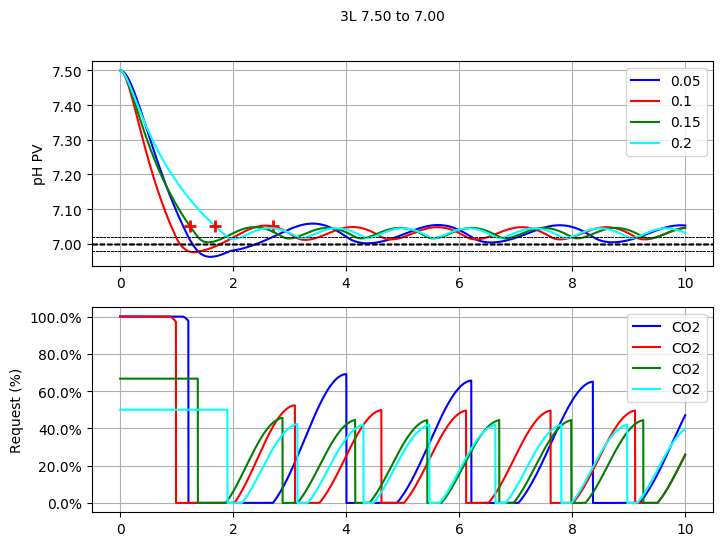

In [55]:
setup8()
ops.initial_pv = 7.5
ops.set_point = 7.0
ops.initial_actual_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84),0,0)
ops.initial_request_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84), 0, 0)
ops.base_pid.mode = 2
ops.c = 0.000
ops.dc = 0.0000
ops.d2c = 0.00000
for mg in 0.05, 0.10, 0.15, 0.20:
    ops.main_gas = mg
    run8(None, False)
finish8()
t = "3L %.2f to %.2f" % (ops.initial_pv, ops.set_point)
fig.text(0.5, .95, t, ha='center')
#savefig(t)
fig

## 3L Graphs for Report

In [13]:
save_path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-07 pH\\IE00005-07.3 Data\\3L Images\\'
def dt():
    from datetime import date
    d = date.today()
    return d.strftime("%y%m%d")
def savefig(name):
    name = name.replace("/", "_")
    p = save_path + name + " " + dt() + ".png"
    fig.savefig(p)
def ff(f, n=2):
    t = "%%.%df"%n
    return (t % f).rstrip("0")

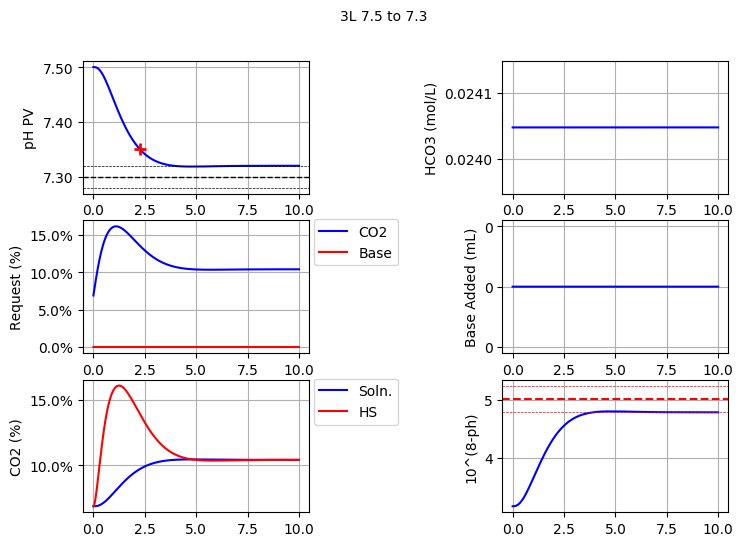

In [20]:
setup7()
ops.initial_pv = 7.5
ops.set_point = 7.3
ops.initial_actual_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84),0,0)
ops.initial_request_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84), 0, 0)
ops.base_pid.mode = 2
ops.c = 0.000
ops.dc = 0.0000
ops.d2c = 0.00000
run7(None, False)
finish7()
t = "3L %s to %s" % (ff(ops.initial_pv), ff(ops.set_point))
fig.text(0.5, .95, t, ha='center')
#savefig(t)
fig

In [67]:
setup7()
ops.initial_pv = 7.3
ops.set_point = 7.5
ops.initial_actual_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84),0,0)
ops.initial_request_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84), 0, 0)
ops.base_pid.mode = 2
ops.c = 0.000
ops.dc = 0.0000
ops.d2c = 0.00000
run7(None, False)
finish7()
t = "3L %s to %s no base" % (ff(ops.initial_pv), ff(ops.set_point))
fig.text(0.5, .95, t, ha='center')
savefig(t)

In [68]:
setup7()
ops.initial_pv = 7.3
ops.set_point = 7.5
ops.initial_actual_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84),0,0)
ops.initial_request_cno = (ph_to_co2(ops.initial_pv, ops.bicarb/84), 0, 0)
ops.base_pid.mode = 0
ops.c = 0.000
ops.dc = 0.0000
ops.d2c = 0.00000
run7(None, False)
finish7()
t = "3L %s to %s base" % (ff(ops.initial_pv), ff(ops.set_point))
fig.text(0.5, .95, t, ha='center')
savefig(t)

In [64]:
setup7()
ops.initial_pv = 7.22
ops.set_point = 7.20
ops.initial_actual_cno = (0.06, 0, 0)
ops.initial_request_cno = (0.06, 0, 0)
ops.base_pid.mode = 0
ops.c = 0.00036
ops.end = 16*hours
run7()

ax1.set_ylim(ops.set_point-0.1, ops.set_point+0.1)
    
finish7()
t = "3L stability constant c=0.00036 mol/L/hr H+ "
fig.text(0.5, .95, t, ha='center')
savefig(t)

In [65]:
setup7()
ops.initial_pv = 7.22
ops.set_point = sp = 7.2
ops.initial_actual_cno = (0.085, 0, 0)
ops.initial_request_cno = (0.085, 0, 0)
ops.end = 16 * hours
ops.initial_request_base = 0
ops.c = 0.00018
ops.dc = 0.000036
ops.d2c = 0.00000
ops.base_pid.mode = 0
run7()

ax1.set_ylim(ops.set_point-0.1, ops.set_point+0.1)
finish7()
t = "3L stability dc=0.00036 mol/L/hr/hr H+"
fig.text(0.5, .95, t, ha='center')
savefig(t)

In [66]:
setup7()
ops.initial_pv = 7.22
ops.set_point = sp = 7.2
ops.initial_actual_cno = (0.085, 0, 0)
ops.initial_request_cno = (0.085, 0, 0)
ops.end = 16 * hours
ops.initial_request_base = 0
ops.c = 0.00018
ops.dc = 0.000018
ops.d2c = 0.0000036
ops.base_pid.mode = 0
run7()

ax1.set_ylim(ops.set_point-0.1, ops.set_point+0.1)
    
finish7()
t = "3L stability d2c=0.00036 mol/L/hr/hr/hr H+"
fig.text(0.5, .95, t, ha='center')
savefig(t)